In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle as pkl
import sys
import torch
from typing import Optional

from mlcg.nn import SumOut

sys.path.insert(0, os.path.join("../.."))
from mlcg_tk.input_generator.prior_gen import PriorBuilder
from mlcg_tk.prior_tools import symmetrized_keys_generator, optimal_offset, prior_evaluator

`mlcg_opt_radius` not installed. Please check the `opt_radius` folder and follow the instructions.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.


In [2]:
plots_path = "./temp_figs"
if not os.path.isdir(plots_path):
    os.mkdir(plots_path)
# select the temperature for your simulations
temperature = 300
kB = 0.0019872041  # kcal/(mol⋅K)
beta = 1 / (temperature * kB)

In [3]:
prior_model = torch.load("./prior_model_example.pt")

/tmp/ipykernel_676176/3016602745.py:1: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  prior_model = torch.load("./prior_model_example.pt")


In [4]:
with open("./prior_builders_example.pck", "rb") as f:
    prior_builders = pkl.load(f)

In [5]:
for idx, prior_bldr in enumerate(prior_builders):
    print(f"Index: {idx}, prior builder: {prior_bldr.name}")

Index: 0, prior builder: bonds
Index: 1, prior builder: angles
Index: 2, prior builder: non_bonded


In [6]:
def basic_prior_visual_inspection(
    prior_bldr: PriorBuilder,
    prior_model: SumOut,
    beta: float,
    xlims = tuple[float,float],
    savedir: Optional[str] = None,
    n_max_figs: Optional[int] = None,
):
    r"""
    Function to plot the free energy distribution compared to the prior curve 
    
    This function will plot the comparison between the free energy distribution
    and the prior fit that should match it for every bead combination that was 
    found for the fit. The purpose of this function is to exemplify how to 
    extract the histograms fro the prior builder and how to correctly 
    compare this to the prior.

    Normally the bead combinations are too many to be analyzed on a one-by-one basis.
    This function can easily modified to filter the histograms and only plot the ones
    that fail according to some criteria 


    Parameters
    ----------

    prior_bldr:
        PriorBuilder object from which we will get the histograms
    prior_model:
        Prior as a mlcg.nn.SumOut object. It must contain a module whose name
        coincides with the `prior_bldr` object
    beta:
        the inverse temperature (1/(KB*T)) in the energy units used by the prior model
    xlims: 
        x-axis limits of the plots to be generated. This value depends on the prior type
        to analyse and CG resolution.
    savedir:
        dictionary where to save every plot generated
    n_max_figs:
        maximum number of figures to plot.
    
    """
    name = prior_bldr.name
    # getting statistics: 
    stats = prior_bldr.histograms.data[name]
    # getting all  the bead combinations for which we collected statistics
    keys = stats.keys()
    # getting bin centers
    bin_centers = prior_bldr.histograms.bin_centers
    # generating the list of possible bead combinations respecting symmetries
    unique_keys = symmetrized_keys_generator(len(list(keys)[0]))
    # intersecting the keys to avoid duplicating plots
    keys_list = [key for key in keys if key in unique_keys]
    print(f"Making plot for prior {name}")
    print(f"found {len(keys)} keys ({len(keys_list)} of which are unique)")
    # get the prior module corresponding to this model
    prior_module = prior_model.models[name].model
    # this range controls how many different figures will we plot
    counter = 0
    for key, hist in stats.items():
        if (counter % 25) ==0:
            fig,axs = plt.subplots(ncols=5,nrows=5,sharex=True,figsize=(10,10),gridspec_kw={"wspace":0.3,"hspace":0.3})
        mask = hist > 1e-1
        dG = torch.tensor(-np.log(hist[mask])/beta)
        xs_fit = bin_centers[mask]
        ys_fit = dG
        #fig,ax = plt.subplots()
        ax = axs.ravel()[(counter % 25)]
        ax.scatter(xs_fit,ys_fit)

        prior_eval_at_fit_data = prior_evaluator(prior_module, key, bin_centers[mask])
        offset=0
        #offset = align_curves_vertical(ys_fit.numpy(),prior_eval_at_fit_data.numpy())
        offset = optimal_offset(ys_fit.numpy(),prior_eval_at_fit_data.numpy())
        full_prior_range = torch.linspace(xlims[0],xlims[1],201)
        
        #prior_eval_at_full_range = Polynomial.compute(torch.tensor(full_prior_range),ks,v_0) + offset
        prior_eval_at_full_range = prior_evaluator(prior_module,key,full_prior_range) + offset
        ax.plot(full_prior_range, prior_eval_at_full_range,color="red")

        x1 = bin_centers[mask][0]
        x2 = bin_centers[mask][-1]
        y1 = ys_fit.min()
        y2 = ys_fit.max()
        axins = ax.inset_axes((0.25,0.4,0.4,0.5),xlim=(x1,x2),ylim=(y1,y2))
        axins.scatter(xs_fit,ys_fit)
        axins.plot(full_prior_range,prior_eval_at_full_range,color="red")
        axins.tick_params(axis='both', which='both',labelsize=6)
        ax.set_xlim(*xlims)
        #axins.set_xlim(*xlims)
        ax.indicate_inset_zoom(axins,edgecolor="black")
        ax.set_title(f"key: {key}")
        if (counter % 5 )==0:
            ax.set_ylabel("FE (kcal/mol)")
        if (counter // 5) ==4:
            ax.set_xlabel(f"{name} value")
        counter += 1
        if (counter % 25) ==0 or counter == (len(stats)):
            plot_num = int(np.ceil(counter/25))
            fig.suptitle(f"Prior {name}, Plot {plot_num}",y=0.92)
            if savedir is not None:
                plt.savefig(f"{savedir}/{name}_{plot_num}.png", dpi=200)
            plt.show()
        if n_max_figs is not None and  counter//25 >= n_max_figs:
            break
        

Making plot for prior bonds
found 400 keys (210 of which are unique)


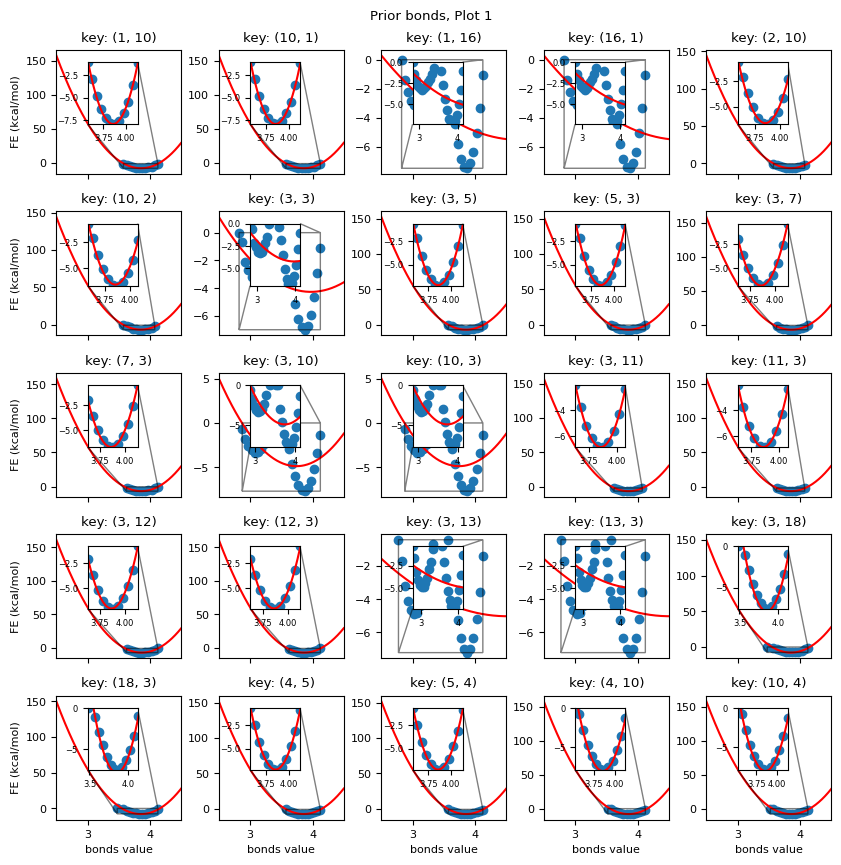

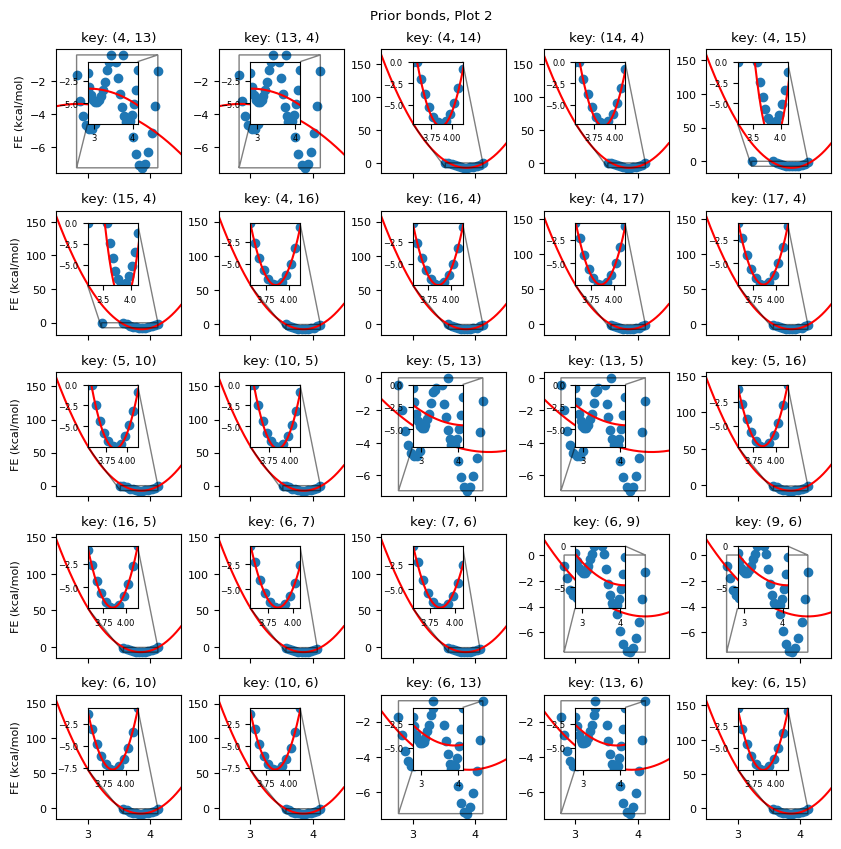

In [7]:
basic_prior_visual_inspection(
    prior_bldr = prior_builders[0],
    prior_model=prior_model,
    beta=beta,
    xlims=(2.5,4.5),
    n_max_figs=2,
    savedir=plots_path,
)

Making plot for prior angles
found 7893 keys (4136 of which are unique)


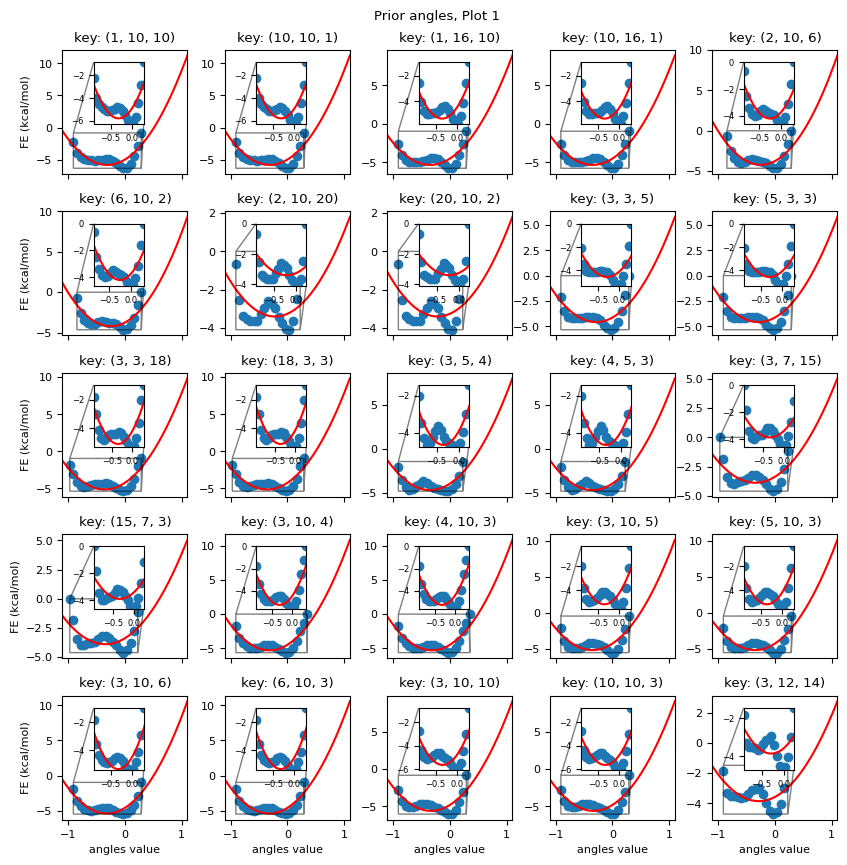

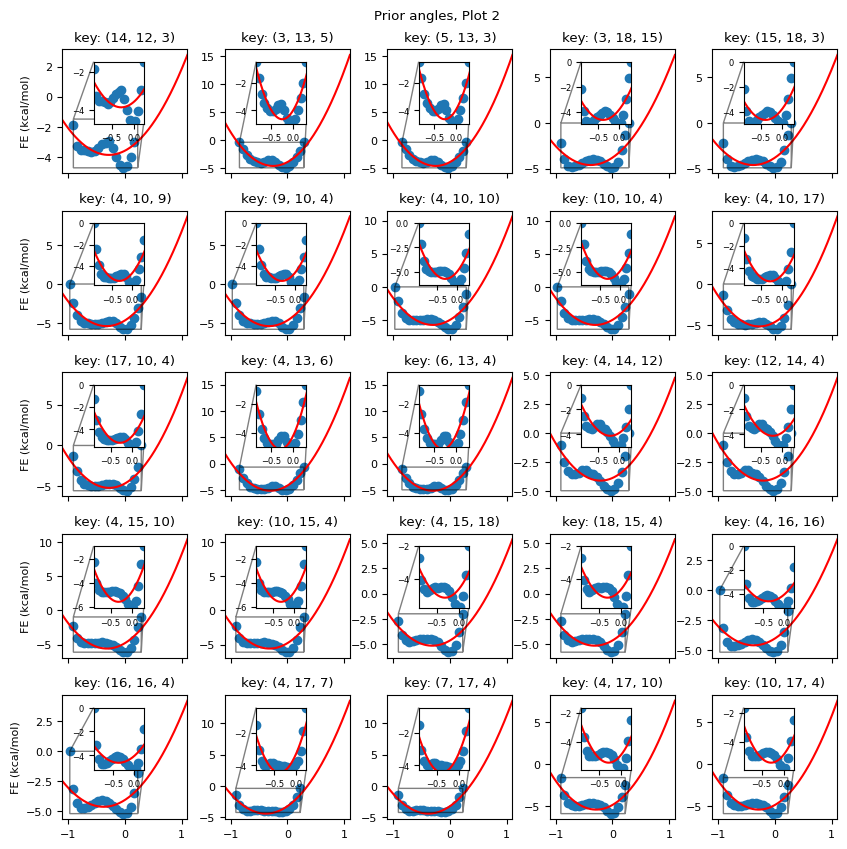

In [8]:
basic_prior_visual_inspection(
    prior_bldr = prior_builders[1],
    prior_model=prior_model,
    beta=beta,
    xlims=(-1.1,1.1),
    n_max_figs=2,
    savedir=plots_path,
)

Making plot for prior non_bonded
found 400 keys (210 of which are unique)


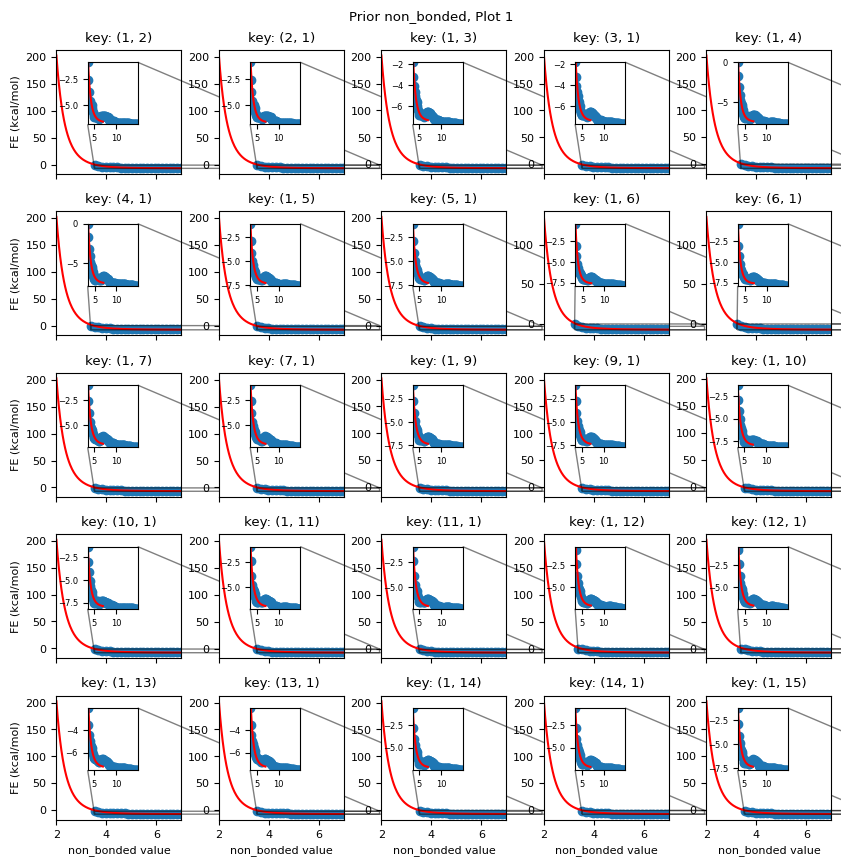

In [9]:
basic_prior_visual_inspection(
    prior_bldr = prior_builders[2],
    prior_model=prior_model,
    beta=beta,
    xlims=(2,7),
    n_max_figs=1,
    savedir=plots_path,
)

In [10]:
def compare_2d_tensors(target,ref,cm="viridis"):
    r"""Function to compare two 2D tensors using a heatmap

    Useful for comparing the value between two sigmas in different nonbonded-fits,
    the reference can also be just arbitrary. A heatmap will be plotted for the 
    difference between the target and the difference.

    Parameters:
    -----------
    target:
        2D array (numpy,torch) that we want to examine
    reference:
        2D array (numpy,torch) that can serve as a baseline for the values of target
    cm:
        Matplotlib colormap name to plot the heatmaps
    """
    fig,axs = plt.subplots(nrows=1,ncols=3,sharex=True,sharey=True,figsize=(10,4))
    a = min(target.min(),ref.min())
    b = max(target.max(),ref.max())
    cmap = plt.get_cmap(cm)
    im_target = axs[0].imshow(target,vmin=a,vmax=b,cmap=cmap)
    axs[0].set_title("Target")
    im_ref = axs[1].imshow(ref,vmin=a,vmax=b,cmap=cmap)
    axs[1].set_title("Reference")
    cbar = fig.colorbar(im_ref,ax=axs[0:2],orientation="vertical",shrink=0.6,pad=0.03)
    diff = target-ref
    diff_range = abs(diff).max()
    mean_diff = diff[diff != 0 ].mean()
    im_diff = axs[2].imshow(diff,vmin=-diff_range,vmax=diff_range,cmap="bwr")
    axs[2].set_title(f"Difference, mean: {mean_diff:0.2f}")
    fig.colorbar(im_diff,ax=axs[2:3],orientation="vertical",shrink=0.6,pad=0.03)
    return fig,axs

In [11]:
new_sigmas = prior_model.models["non_bonded"].model.sigma

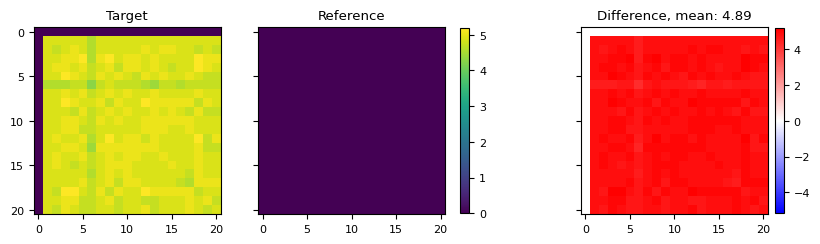

In [12]:
# we use zeros as the reference as we don't have anything to compare the prior to
fig,axs = compare_2d_tensors(new_sigmas,torch.zeros(*new_sigmas.shape))